In [2]:
import os
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

totalWordCount = {}
Books = []
booksTotal = []
bookNames = []
regex = '([^A-Za-z ]+)'

stopWords = []

fil = open('common-english-words.txt')
for line in fil:
    newWords = line.strip().split(',')
    stopWords.append(newWords)

for file in os.listdir('books/'):
    fin = open('books/' + file)
    ##THIS HANDLES GETTING THE TITLE
    
    lineCont = []
    start = False
    lineRegex = '(Title: )'
    
    while start == False:
        line = fin.readline()
        line = line.strip()
        if re.match(lineRegex, line) != None:
            start = True
            lineCont = line.split(':')
            bookNames.append(lineCont[-1])
    
    
    ## THIS HANDLES THE BOOK
    bookWordCount = {}
    bookTotal = 0
    for line in fin:
        wordString = re.sub(regex, '', line).lower()
        wordArray = wordString.split(' ')
        ##wordArray = re.findall('([A-Za-z]*)', wordString)
        
        bookTotal += len(wordArray)
        for word in wordArray:
            if word == '':
                break
            elif word not in totalWordCount:
                totalWordCount[word] = 1
            else:
                totalWordCount[word] += 1
            if word == '':
                break
            elif word not in bookWordCount:
                bookWordCount[word] = 1
            else:
                bookWordCount[word] += 1
         
    Books.append(bookWordCount)
    booksTotal.append(bookTotal)


This code above parses each book in the books directory. There are 50 books. For each book in that directory it finds the title, then parses the contents of the .txt file for words. 

While going through each book it keeps track of the word count for both the book and the entire corpus in order to find the top words used by the corpus.

Filling out the word counts for each book will also be important when creating the normalized freq. 

The main outputs from this are the list of dictionaries that contain the word counts for each book, and the dictionary that contains the word count for the corpus.

In [3]:
import operator
top20words = sorted(totalWordCount, key=totalWordCount.get, reverse=True)[:20]
print(top20words)

['the', 'and', 'of', 'to', 'a', 'in', 'i', 'he', 'that', 'was', 'it', 'his', 'you', 'with', 'is', 'had', 'as', 'her', 'for', 'not']


top20words gathers the top 20 words over the entire set. http://stackoverflow.com/questions/7197315/5-maximum-values-in-a-python-dictionary Helped me figure out how to sort the values to the keys in order to find the top 20 for the set.

So the top words are all really common words. I will do the analysis on these first then remove them later.

In [4]:
freq = []
i = 0
for bookDict in Books:
    bookFreq = []
    for word in top20words:
        if word in bookDict:
            bookFreq.append((bookDict[word]/booksTotal[i]))
        else:
            bookFreq.append(0)
    
    i += 1
    freq.append(bookFreq)
    
print(freq[0])

[0.04209497804904165, 0.04075650497911982, 0.018497697826319735, 0.021455723310846987, 0.018323696327229896, 0.011684869900417604, 0.01026608844630046, 0.008673305493093478, 0.010855016597066067, 0.007736374344148196, 0.013531962736909733, 0.004443730592140486, 0.006371131812827926, 0.0063042081593318346, 0.00441696113074205, 0.0063042081593318346, 0.004470500053538923, 0.0012313952243280864, 0.006330977620730271, 0.0040421886711639364]


This converts the frequency of each of the top 20 words per book into a normalized frequency. This is done by dividing the total amount of times that the word occurs by the number of words in the book. So the frequency of the 20 words will not add up to 1, but the total of percentages of all the words would. 

This gives me the freq of each of those words for each book.

In [5]:
from scipy.cluster.vq import kmeans, vq

kvals = []
dists = []
for k in range(2, 11):
    centroids, distortion = kmeans(freq, k)
    kvals.append(k)
    dists.append(distortion)

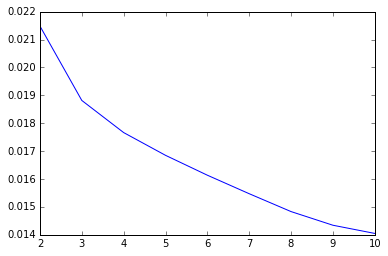

In [6]:
plt.plot(kvals, dists)

In the elbow graph above. With the kmeans value on the x axis and the distortions on the y axis. It bends the most on a k value of 3. So this is the most effective k value that can be used to cluster this data. 

# PCA

In [7]:
data = np.array(freq)

In [8]:
from matplotlib.mlab import PCA
pca = PCA(data)

print(pca.sigma)
print(top20words[:2])

[ 0.01499227  0.01073758  0.00876663  0.0071118   0.00589583  0.00391623
  0.00958324  0.0054877   0.00383368  0.00517567  0.00470905  0.00432481
  0.00539671  0.00242122  0.00404857  0.00348546  0.00216723  0.00572233
  0.00190337  0.00255714]
['the', 'and']


From above you can see that the two highest sigma values, or the highest standard deviations are the first two which are 'the' and 'and'. So these are going to be the biggest factors in the pca graph.

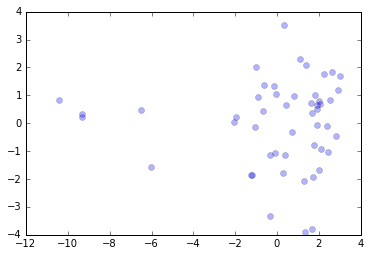

In [9]:
plt.plot(pca.Y[:, 0], pca.Y[:, 1], "o", alpha=0.3)

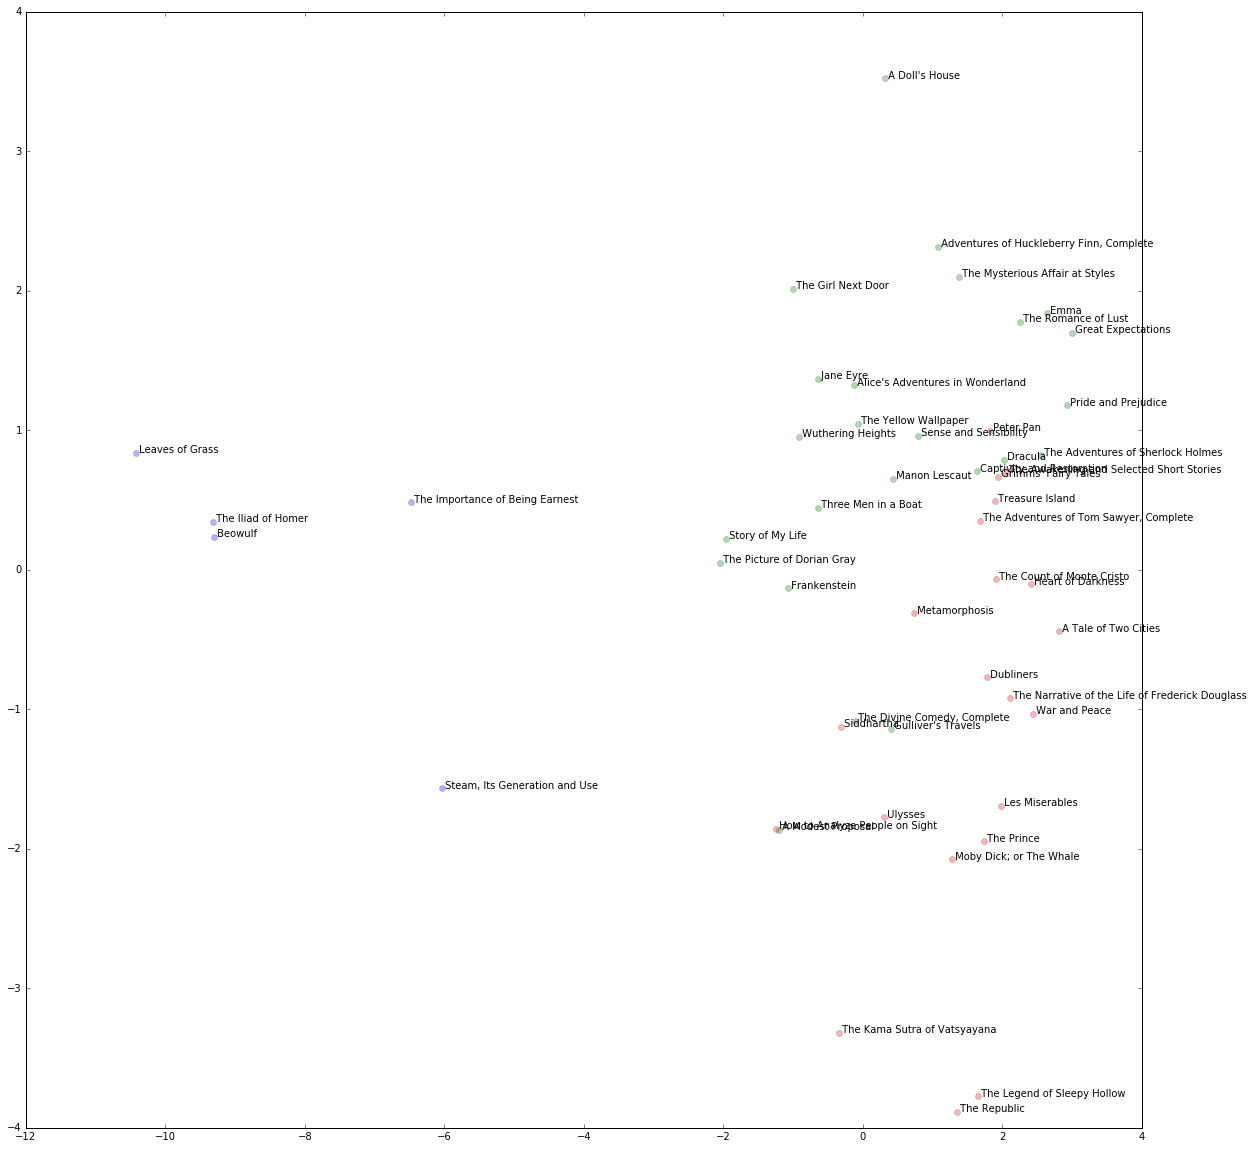

In [10]:
from scipy.cluster.vq import kmeans, vq

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)

k = 3

centroids, dist, = kmeans(data, k)
idx, _ = vq(data, centroids)

for i in range(k):
    plt.plot(pca.Y[idx==i, 0], pca.Y[idx==i, 1], "o", alpha=0.3)

j = 0
for point in zip(pca.Y[:, 0], pca.Y[:, 1]):
    ax.annotate('%s' % bookNames[j], xy=point, textcoords='data')
    j+=1
    


In [13]:
pca.Wt[0]
print(top20words, pca.Wt[2])

['the', 'and', 'of', 'to', 'a', 'in', 'i', 'he', 'that', 'was', 'it', 'his', 'you', 'with', 'is', 'had', 'as', 'her', 'for', 'not'] [ 0.01475419  0.0081417  -0.13462899 -0.05040681  0.01816052 -0.11849225
 -0.2153662   0.24579885 -0.17393705  0.32230058 -0.07271673  0.33271853
 -0.21883085  0.11630119 -0.57217328  0.36807191 -0.120695    0.13010321
 -0.14509671 -0.17589753]


Figure out what the dimensions mean. So if the some book has a positive correlation with one dimension, it may have some other correlation with another. 


http://stackoverflow.com/questions/22272081/label-python-data-points-on-plot   Helped me annotate my graph to get the book titles to populate

x axis is PCA component 1

y axis is PCA component 2

So the first two will be the top two words used total over all the books. So 'the' and 'and' are the two highest used words, but also the words with the greatest standard deviation. So from this you can see that you can't have both a very low correlation of the x axis and a very low correlation of y axis. A lot of book seem to have high values for the x axis, and vary alot on the y axis. So this doesn't really tell us much but I will add in my new book below and then preform the PCA with out the stop words contained in the top list. The top two words are the most influential words, so therefore they should be the first two PCA components.

The grouping of the books seems to be clear. The red group in the middle has a high range on the y axis but is the only one that extends past 1. Blue is to the right of red. It also has a high range of y axis but doesn't extend as far as red. They seem to be, for the most part, negative on the y axis and positive on the x axis. Green is fairly isolated to the left. They range a fair amount for both components, but are clearly very separate from the other groups. 

# Without Stop Words and With New Book: 'The Return of Sherlock Holmes'

The below functions are copies of the previous ones just for the new book, 'the return of sherlock holmes' and also removing the stop words from the corpus

In [219]:
totalWordCount = {}
Books = []
booksTotal = []
bookNames = []
regex = '([^A-Za-z ]+)'

stopWords = []

fil = open('common-english-words.txt')
for line in fil:
    stopWords = line.strip().split(',')

for file in os.listdir('booksPlusOne/'):
    fin = open('booksPlusOne/' + file)
    ##THIS HANDLES GETTING THE TITLE
    
    lineCont = []
    start = False
    lineRegex = '(Title: )'
    
    while start == False:
        line = fin.readline()
        line = line.strip()
        if re.match(lineRegex, line) != None:
            start = True
            lineCont = line.split(':')
            bookNames.append(lineCont[-1])
    
    
    ## THIS HANDLES THE BOOK
    bookWordCount = {}
    bookTotal = 0
    for line in fin:
        wordString = re.sub(regex, '', line).lower()
        wordArray = wordString.split(' ')
        ##wordArray = re.findall('([A-Za-z]*)', wordString)
        
        bookTotal += len(wordArray)
        for word in wordArray:
            if word not in stopWords:
                
                if word == '':
                    break
                elif word not in totalWordCount:
                    totalWordCount[word] = 1
                else:
                    totalWordCount[word] += 1
                if word == '':
                    break
                elif word not in bookWordCount:
                    bookWordCount[word] = 1
                else:
                    bookWordCount[word] += 1
         
    Books.append(bookWordCount)
    booksTotal.append(bookTotal)

In [220]:
import operator
top20words = sorted(totalWordCount, key=totalWordCount.get, reverse=True)[:20]
print(top20words)

['one', 'out', 'up', 'more', 'very', 'man', 'now', 'time', 'well', 'little', 'see', 'such', 'know', 'before', 'two', 'mr', 'down', 'upon', 'over', 'good']


In [221]:
freq = []
i = 0
for bookDict in Books:
    bookFreq = []
    for word in top20words:
        if word in bookDict:
            bookFreq.append((bookDict[word]/booksTotal[i]))
        else:
            bookFreq.append(0)
    
    i += 1
    freq.append(bookFreq)


[0.0036720224044131957, 0.002343664069176164, 0.0020475332301105836, 0.0017937067966258006, 0.0028259342927972517, 0.003062838964049716, 0.0018867764889035545, 0.0014045062652824666, 0.0024451946425700774, 0.0010745319017522485, 0.002013689705645946, 0.0010491492584037703, 0.0013791236219339881, 0.0014468106708632638, 0.0013622018597016694, 0.0034520394953930504, 0.00164987181765109, 0.0034774221387415287, 0.0013706627408178287, 0.0008968533983129003]


In [222]:
data = np.array(freq)

In [223]:
from matplotlib.mlab import PCA
pca = PCA(data)

print(top20words[2], pca.sigma[2])
print(top20words[15], pca.sigma[15])

up 0.00132911879654
mr 0.00184187107947


From this I have taken the two highest sigma values from my pca data set. I had to manually search but 'mr' and 'up are the words with the highest standart deviation within the top 20 words. These will have the greatest effect on the pca graph

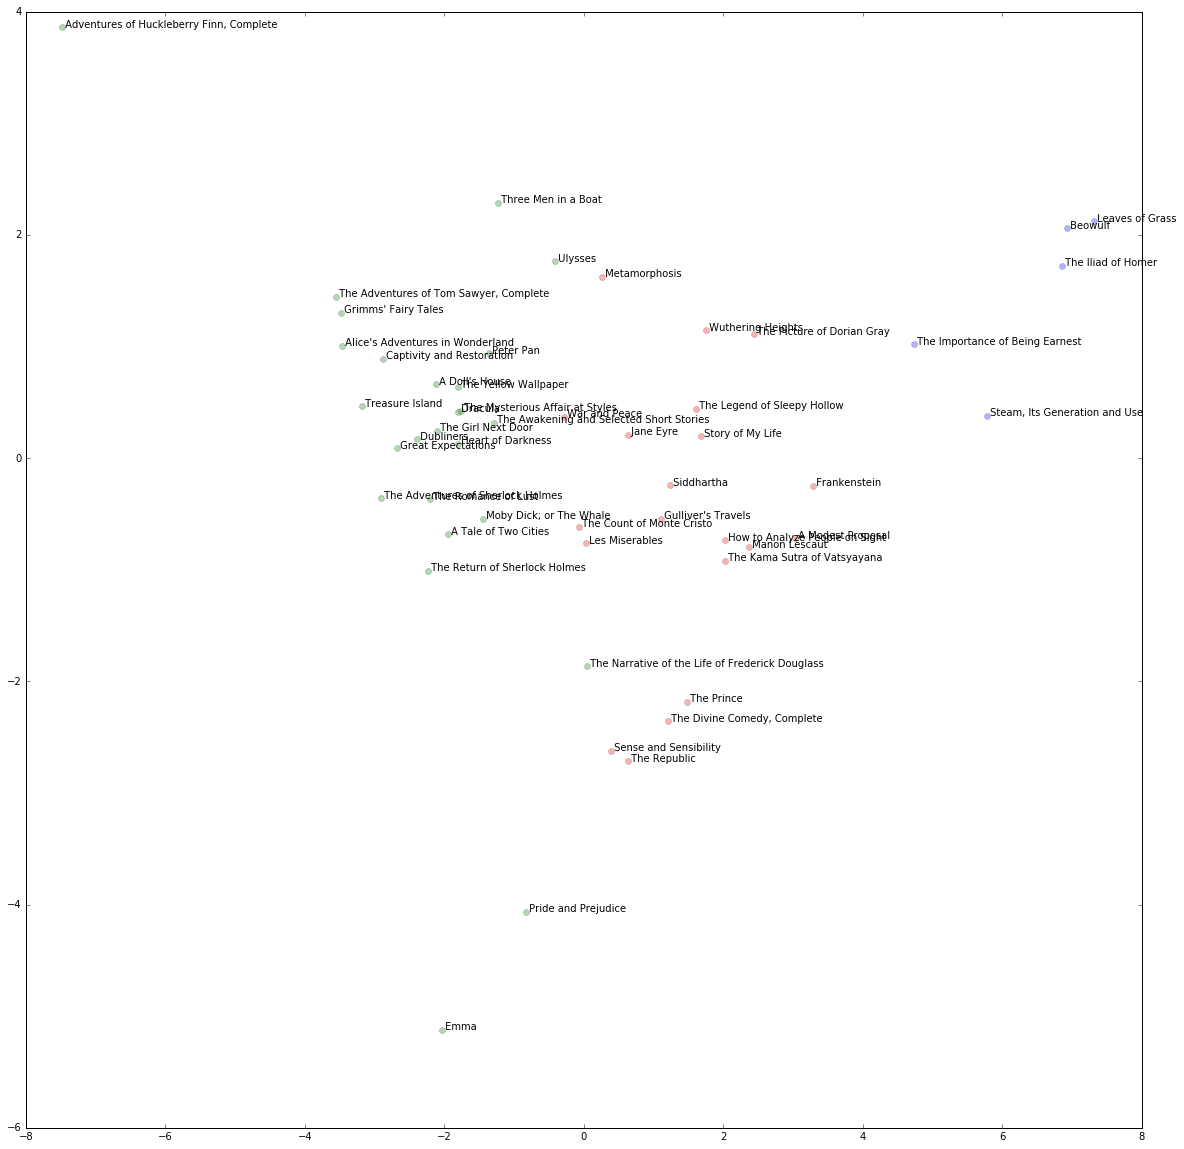

In [203]:
from scipy.cluster.vq import kmeans, vq

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)

k = 3

centroids, dist, = kmeans(data, k)
idx, _ = vq(data, centroids)

for i in range(k):
    plt.plot(pca.Y[idx==i, 0], pca.Y[idx==i, 1], "o", alpha=0.3)

j = 0
for point in zip(pca.Y[:, 0], pca.Y[:, 1]):
    ax.annotate('%s' % bookNames[j], xy=point, textcoords='data')
    j+=1

Since 'mr' has the highest deviation it will be a large factor in determining the placement of the books. I think that it is one of the most deviated words becuase older texts may not use the word. 'up' is the second highest deviated word, so this would be another word that are effecting the axis more than other words. 

A large majority of the values are centered around the 0 point on both axis, so this means that these words dont have much of role in the deviation of these books. No book has a low component value for both axis. But most seem to be around 0, 0 or positive for both axis. 

The grouping of these books makes some sense, but books like the 'iliad of homer' and 'the republic' should be near eachother since they were written a very long time ago. However, I really think that it is hard to compare some of these books because they were not originally written in english, meaning that the words placed in the text are entirely dependent on the translator. The grouping of red is centered in the graph, where as the group of blue is off to the right and up. Green seems to stretch the farthes from the bottom of the graph to the top, but they take up the entire left side. 

When placing my new book, 'the return of sherlock holmes', I had a feeling that it would be around that of 'the adventures of sherlock holmes'. They have the same author and were written around the same time period. This means that they should contain the same language. 


20